# Managing the session contents

<figure style="display: table; text-align:center; margin-left: auto; margin-right:auto">

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/simphony/docs/v4.0.0?filepath=docs%2Fusage%2Fsessions%2Fmanagement.ipynb "Click to run this tutorial yourself!")
    
</figure>

As said, sessions can be though of as a "box" that stores ontology individuals. Consequently, adding and removing individuals are among the operations that can be performed on them. 

As described in [one of the previous sections](../assertional_knowledge.ipynb), in SimPhoNy, an ontology individual is characterized by

- the information about the ontology individual itself such as the classes it belongs to, its label and its attributes;
- the connections to other ontology individuals.

The methods [add](../../api_reference.md#simphony_osp.session.Session.add) and [delete](../../api_reference.md#simphony_osp.session.delete) try to accommodate this definition. To see how they work, consider a city example again.

In [1]:
from simphony_osp.namespaces import city

freiburg = city.City(name="Freiburg", coordinates=[47.997791, 7.842609])

neighborhoods = {
    city.Neighborhood(name=name, coordinates=coordinates)
    for name, coordinates in [
        ('Altstadt', [47.99525, 7.84726]),
        ('Stühlinger', [47.99888, 7.83774]),
        ('Neuburg', [48.00021, 7.86084]),
        ('Herdern', [48.00779, 7.86268]),
        ('Brühl', [48.01684, 7.843]),
    ]
}

citizen_1 = city.Citizen(name='Nikola', age=35)
citizen_2 = city.Citizen(name='Lena', age=70)

freiburg[city.hasPart] |= neighborhoods
freiburg[city.hasInhabitant] += citizen_1, citizen_2

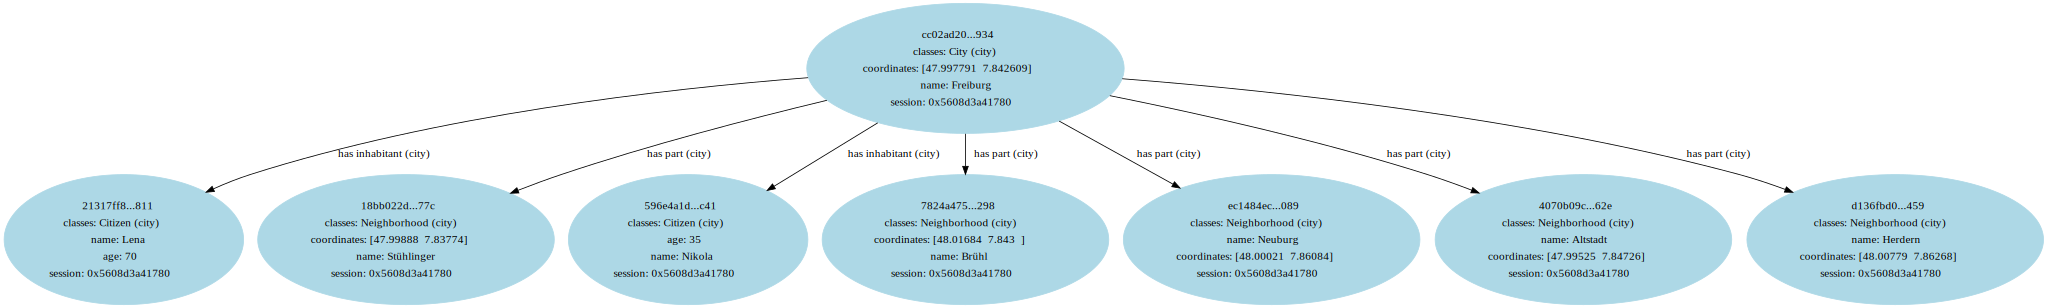

In [2]:
from simphony_osp.tools import semantic2dot  # explained in a later section

semantic2dot(freiburg, *neighborhoods, citizen_1, citizen_2)

<div class="admonition important">
<div class="admonition-title" style="font-weight: bold"><div style="display: inline-block">Tip</div></div>
    
On most web browsers (including mobile ones), you can right-click the picture above and then click "open in new tab" to see the picture in its full size.
    
</div>

Then create a new session to transfer individuals to.

In [3]:
from simphony_osp.session import Session

session = Session()

Passing any individual to the method [add](../../api_reference.md#simphony_osp.session.Session.add) of the new session creates a copy of it. The copy contained in the new session is assigned the same identifier as the original.

In [4]:
freiburg_copy = session.add(freiburg)
list(session), freiburg_copy.name, freiburg_copy.coordinates, freiburg_copy.get()

([<OntologyIndividual: cc02ad20-4c05-4257-8f40-47bb0e243934>],
 'Freiburg',
 <simphony_osp.utils.datatypes.Vector: array([47.997791, 7.842609])>,
 set() <http://www.w3.org/2002/07/owl#topObjectProperty of ontology individual cc02ad20-4c05-4257-8f40-47bb0e243934>)

In the example above, the variable `freiburg` refers now to the individual in the Core Session, while `freiburg_copy` refers to the copy of the individual that has been created in the new session.

As it can be inferred from the fact that the new session contains only one individual, only the _intrinsic_ information about the individual has been transferred, but not the connections to other ontology individuals nor any intrinsic information of the other ontology individuals themselves.

To keep the connection to another ontology individual, it is necessary to transfer **both of them together**.

In [5]:
session.clear()  # this removes all individuals from the session

copies = session.add(freiburg, neighborhoods)  # note that Python iterables of individuals can also be passed to `add` (such as `neighborhoods`)
freiburg_copy = copies[0]  # the order in which individuals were added is respected
freiburg_copy.get()

{<OntologyIndividual: 7824a475-52e0-48b3-ac15-95cbe1d11298>, <OntologyIndividual: ec1484ec-94df-4bfc-bf37-ece246888089>, <OntologyIndividual: d136fbd0-3eb8-482b-908f-b5755cd94459>, <OntologyIndividual: 4070b09c-ab77-439b-8404-5e4fd1e0662e>, <OntologyIndividual: 18bb022d-3c87-4d0d-8bde-527ffe5b877c>} <http://www.w3.org/2002/07/owl#topObjectProperty of ontology individual cc02ad20-4c05-4257-8f40-47bb0e243934>

As shown in the example, the [clear](../../api_reference.md#simphony_osp.session.Session.clear) method removes all ontology individuals from a session. The [delete](../../api_reference.md#simphony_osp.session.Session.delete) method allows to exactly select the individuals to remove. Both ontology individuals and identifiers can be passed to [delete](../../api_reference.md#simphony_osp.session.Session.delete).

In [6]:
session.delete(freiburg.identifier, copies[1:])
list(session)

[]

A special situation arises when one tries to add an ontology individual to a session that already contains an individual with the same identifier.

In [7]:
session_A = Session(); session_A.locked = True
with session_A:
    lena_A = city.Citizen(name='Lena', age=70,
                          iri='https://example.org/entities#Lena')

session_B = Session(); session_B.locked = True
with session_B:
    lena_B = city.Citizen(name='Helena', age=31,
                          iri='https://example.org/entities#Lena')

In [8]:
with Session() as session:
    session.add(lena_A)
    session.add(lena_B)  # -> Fails, there is already an individual with the same identifier.

RuntimeError: Some of the added entities already exist on the session.

When this happens, an exception is raised. It is still possible to copy the individual, but is necessary to decide whether:

- the existing individual should be overwritten (default) or;
- the new individual should be merged with the existing one.

To apply default action (overwrite), use the keyword argument `exists_ok=True`.

In [9]:
with Session() as session:
    copy = session.add(lena_A)
    print(copy.age, copy.name)
    copy = session.add(lena_B, exists_ok=True)
    print(copy.age, copy.name)

70 Lena
31 Helena


Overwriting replaces the classes, attributes, attribute values and connections to other ontology individuals.

To merge the new individual with the previous one, use `exists_ok=True, merge=True` instead.

In [10]:
with Session() as session:
    copy = session.add(lena_A)
    print(copy.age, copy.name)
    copy = session.add(lena_B, exists_ok=True, merge=True)
    print(copy['age'], copy['name'])

70 Lena
{70, 31} {'Helena', 'Lena'}


Merging combines the classes, atrributes, attribute values and connections of the two individuals.